# Données spatiales: découverte de geopandas

``` python
import sys
sys.path.insert(1, '../../../../') #insert the utils module
from utils import print_badges

#print_badges(__file__)
print_badges("content/course/manipulation/03_geopandas_tutorial.qmd")
```

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABmanipulation%2003_geopandas_tutorial%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=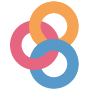" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

Dans ce tutoriel, nous allons utiliser les données suivantes :

-   [Localisations des stations velib](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr) ;
-   [fonds de carte `AdminExpress`](https://geoservices.ign.fr/adminexpress) à
    travers un package `Python` nommé [`cartiflette`](https://github.com/InseeFrLab/cartogether)
    facilitant la récupération de cette source.

La représentation des données, notamment la cartographie, est présentée plus
amplement dans la partie [visualiser](#visualiser). Quelques méthodes
pour faire rapidement des cartes seront présentées ici, mais
l’objet de ce chapitre porte davantage sur la manipulation des données géographiques.

Ce tutoriel s’inspire beaucoup d’un autre tutoriel que j’ai fait pour
`R` disponible
[dans la documentation `utilitr`](https://www.book.utilitr.org/spatdata.html).
Il peut servir de pendant à celui-ci pour l’utilisateur de `R`.

Quelques installations préalables sont nécessaires :

``` python
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas
!pip install topojson
```

In [2]:
!pip install topojson

Pour être en mesure d’exécuter ce tutoriel, les imports suivants
seront utiles.

In [3]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning:

The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.


# Données spatiales: quelle différence avec des données traditionnelles ?

**Le terme “données spatiales” désigne les données qui portent sur les caractéristiques géographiques des objets (localisation, contours, liens)**.
Les caractéristiques géographiques des objets sont décrites à l’aide d’un **système de coordonnées**
qui permettent une représentation dans un espace euclidien ($(x,y)$).
Le passage de l’espace réel (la Terre, qui est une sphère) à l’espace plan
se fait grâce à un **système de projection**. Voici quelques exemples
de données spatiales :

-   Une table décrivant des bâtiments, avec les coordonnées géographiques de chaque bâtiment;
-   Le découpage communal du territoire, avec le contour du territoire de chaque commune;
-   Les routes terrestres, avec les coordonnées décrivant leur parcours.

Les données spatiales rassemblent classiquement deux types de données :

1.  des **données géographiques** (ou géométries): objets géométriques tels que des points, des vecteurs, des polygones, ou des maillages (*raster*). Exemple: la forme de chaque chaque commune, les coordonnées d’un bâtiment;
2.  des **données attributaires** (ou attributs): des mesures et des caractéristiques associés aux objets géométriques. Exemple: la population de chaque commune, le nombre de fenêtres et le nombre d’étages d’un bâtiment.

**Les données spatiales sont fréquemment traitées à l’aide d’un système d’information géographique (SIG)**, c’est-à-dire un système d’information capable de stocker, d’organiser et de présenter des données alphanumériques spatialement référencées par des coordonnées dans un système de référence (CRS). `Python` dispose de fonctionnalités lui permettant de réaliser les mêmes tâches qu’un SIG (traitement de données spatiales, représentations cartographiques).

**Les systèmes de projection font l’objet de standards internationaux et sont souvent désignés par des codes dits codes EPSG**. Ce [site](https://epsg.io/) est un bon aide-mémoire. Les plus fréquents, pour les utilisateurs français, sont les suivants (plus d’infos [ici](https://geodesie.ign.fr/contenu/fichiers/documentation/SRCfrance.pdf)):

-   `2154`: système de projection Lambert 93. Il s’agit du système de projection officiel. La plupart des données diffusées par l’administration pour la métropole sont disponibles dans ce système de projection.
-   `27572`: Lambert II étendu. Il s’agit de l’ancien système de projection officiel. Les données spatiales anciennes peuvent être dans ce format.
-   `4326`: WGS 84 ou système de pseudo-Mercator. Attention, ce n’est en réalité pas un système de projection mais un système de coordonnées (longitude / latitude) qui permet simplement un repérage angulaire sur l’ellipsoïde. Il est utilisé pour les données GPS.

## De `pandas` à `geopandas`

Le *package* `geopandas` est une boîte à outils conçue pour faciliter la manipulation de données spatiales. **La grande force de `geopandas` est qu’il permet de manipuler des données spatiales comme s’il s’agissait de données traditionnelles**, car il repose sur le standard ISO 19125 [*simple feature access*](https://en.wikipedia.org/wiki/Simple_Features) défini conjointement par l’*Open Geospatial Consortium (OGC)* et l’*International Organization for Standardization (ISO)*.

Par rapport à un DataFrame standard, un objet `geopandas` comporte
une colonne supplémentaire: `geometry`. Elle stocke les coordonnées des
objets géographiques (ou ensemble de coordonnées s’agissant de contours). Un objet `geopandas` hérite des propriétés d’un
DataFrame pandas mais propose des méthodes adaptées au traitement des données spatiales.

Ainsi, grâce à `Geopandas`, on pourra effectuer des manipulations sur les attributs des données comme avec `pandas` mais on pourra également faire des manipulations sur la dimension spatiale des données. En particulier,

-   Calculer des distances et des surfaces;
-   Agréger rapidement des zonages (regrouper les communes en département par exemple);
-   Trouver dans quelle commune se trouve un bâtiment à partir de ses coordonnées géographiques;
-   Recalculer des coordonnées dans un autre système de projection.
-   Faire une carte, rapidement et simplement

<div class="alert alert-warning" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #ffc10780;">
<h3 class="alert-heading"><i class="fa fa-lightbulb-o"></i> Hint</h3>

Les manipulations de données sur un objet `Geopandas` sont nettement plus lentes que sur
un `DataFrame` traditionnel (car `Python` doit gérer les informations géographiques pendant la manipulation des données).
Lorsque vous manipulez des données de grandes dimensions,
il peut être préférable d’effectuer les opérations sur les données avant de joindre une géométrie à celles-ci.

</div>

Par rapport à un logiciel spécialisé comme `QGIS`, `Python` permettra
d’automatiser le traitement et la représentation des données. D’ailleurs,
`QGIS` utilise lui-même `python`…

# Importer des données spatiales

Les données spatiales sont plus riches que les données traditionnelles car elles
incluent, habituellement, des éléments supplémentaires pour placer dans
un espace cartésien les objets. Cette dimension supplémentaire peut être simple
(un point comporte deux informations supplémentaire: $x$ et $y$) ou
assez complexe (polygones, lignes avec direction, etc.)

Les formats les plus communs de données spatiales sont les suivants :

-   *shapefile* (`.shp`): format (**propriétaire**) le plus commun de données géographiques.
    La table de données (attributs) est stockée dans un fichier séparé des
    données spatiales. En faisant `geopandas.read_file("monfichier.shp")`, le
    package fait lui-même le lien entre les observations et leur représentation spatiale ;
-   *geopackage* (`.gpkg`) : ce (relativement) nouveau format **libre** en un seul fichier également (lui recommandé par l’OGC) vise progressivement à se substituer au shapefile. Il est par exemple le format par défaut dans QGIS.
-   *geojson* (`.json`) : ce format, non préconisé par l’OGC est largement utilisé pour le développement web
    comme dans la librairie `leaflet.js`.
    La dimension spatiale est stockée dans le même fichier que les attributs.
    Ces fichiers sont généralement beaucoup plus légers que les *shapefiles* mais possèdent des limites s’agissant de gros jeux de données.

Cette [page](https://si.ecrins-parcnational.com/blog/2020-02-geojson-shapefile-geopackage.html) compare plus en détail ces trois types de formats de données géographiques.

L’aide de [geopandas](https://geopandas.org/io.html) propose des bouts de code en fonction des différentes situations dans lesquelles on se trouve.

## Exemple: récupérer les découpages territoriaux

L’un des fonds de carte les plus fréquents qu’on utilise est celui des
limites administratives des communes.
Celui-ci peut être récupéré de plusieurs manières.
En premier lieu, pour récupérer
le fond de carte officiel, produit par l’IGN, sous
le nom d’[`AdminExpress`](https://geoservices.ign.fr/adminexpress#telechargementCog)<a name="cite_ref-1"></a>[<sup>\[1\]</sup>](#cite_note-1),
il est possible de se rendre sur le site de l’IGN et de le télécharger depuis
le serveur `FTP`.
Il est également possible d’utiliser l’une des [API de l’IGN](https://api.gouv.fr/les-api/api_carto_cadastre)
mais ces dernières ne sont pas encore très documentées pour des utilisateurs
de `Python`.
Le package `pynsee` propose notamment un module dédié à la récupération de fonds de carte officiels pour valoriser des données
d’open data. L’API sur laquelle il repose étant parfois lente, nous présentons le code dédié uniquement en annexe.

Il existe également une version moins officielle sur [data.gouv](https://www.data.gouv.fr/fr/datasets/decoupage-administratif-communal-francais-issu-d-openstreetmap/), construite à
partir d’`OpenStreetMap`.

Nous proposons ici une méthode nouvelle de récupération de
ces données qui s’appuie sur le projet interministériel
[`cartiflette`](https://10pourcent.etalab.studio/projets/insee/).  
Ce projet vise à faciliter la récupération des sources officielles, notamment
celles de l’IGN, et leur association à des jeux de données géographiques.

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

Le package `cartiflette` est expérimental
et n’est disponible que sur
[`Github`](https://github.com/InseeFrLab/cartogether), pas sur `PyPi`.
Il est amené à évoluer rapidement et cette page sera mise à jour
quand de nouvelles fonctionalités (notamment l’utilisation d’`API`)
seront disponibles pour encore simplifier la récupération de
contours géographiques.

Pour installer `cartiflette`, il est nécessaire d’utiliser les commandes suivantes
depuis un `Jupyter Notebook` (si vous utilisez la ligne de commande directement,
vous pouvez retirer les `!` et `%` en début de ligne):

``` python
!pip install --upgrade botocore==1.23.26  #Sur colab, sinon bug
!pip install --upgrade urllib3==1.22.0 #Sur colab, sinon bug
!pip install py7zr #Sur colab, sinon bug
!pip install s3fs #Sur colab, sinon bug
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .
```

Ces commandes permettent de récupérer l’ensemble du code
source depuis [`Github` <i class="fab fa-github"></i></a>](https://github.com/InseeFrLab/cartiflette)

</div>

Ici, nous sommes intéressés par les contours des communes
de la petite couronne. On pourrait désirer récupérer
l’ensemble de la région Ile-de-France mais nous
allons nous contenter de l’analyse de Paris intra-muros
et des départements limitrophes.
C’est l’un des avantage de `cartiflette` que de faciliter
la récupération de fonds de carte sur un ensemble de département.
Cela évite la récupération d’un fond de carte très
volumineux (plus de 500Mo) pour une analyse restreinte (quelques départements).
Un autre avantage de `cartiflette` est de faciliter la récupération de fonds
de carte consolidés comme celui dont on a besoin ici: arrondissements
dans Paris, communes ailleurs. Comme cela est expliqué dans un encadré à part,
il s’agirait d’une opération pénible à mettre en oeuvre sans `cartiflette`.

Les contours de cet espace peuvent être récupérés de la manière suivante:

In [5]:
import cartiflette.s3 as s3

shp_communes = s3.download_vectorfile_url_all(
    crs = 4326,
    values = ["75", "92", "93", "94"],
    borders="COMMUNE",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

shp_communes.head()

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=75/vectorfile_format='topojson'/provider='IGN'/source='EXPRESS-COG-CARTO-TERRITOIRE'/raw.topojson

Downloading: : 0.00iB [00:00, ?iB/s]

Downloading: : 14.5kiB [00:00, 161kiB/s]


ERROR 1: PROJ: proj_create_from_database: Open of /miniconda/envs/python-ENSAE/share/proj failed

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=92/vectorfile_format='topojson'/provider='IGN'/source='EXPRESS-COG-CARTO-TERRITOIRE'/raw.topojson

Downloading: : 0.00iB [00:00, ?iB/s]

Downloading: : 36.0kiB [00:00, 221kiB/s]

Downloading: : 62.3kiB [00:00, 334kiB/s]

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=93/vectorfile_format='topojson'/provider='IGN'/source='EXPRESS-COG-CARTO-TERRITOIRE'/raw.topojson

Downloading: : 0.00iB [00:00, ?iB/s]

Downloading: : 34.0kiB [00:00, 289kiB/s]

Downloading: : 102kiB [00:00, 424kiB/s] 

Downloading: : 119kiB [00:00, 430kiB/s]

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=94/vectorfile_format='topojson'/provider='IGN'/source='EXPRESS-COG-CARTO-TERRITOIRE'/raw.topojson

Downloading: : 0.00iB [00:00, ?iB/s]

Downloading: : 32.0kiB [00:00, 243kiB/s]

Downloading: : 92.0kiB [00:00, 382kiB/s]

Downloading: : 110kiB [00:00, 400kiB/s] 

On reconnaît la structure d’un `DataFrame` `Pandas`. A cette structure s’ajoute
une colonne `geometry` qui enregistre la position des limites des polygones de chaque
observation.

Comme vu précédemment, le système de projection est un élément important. Il permet à `Python`
d’interpréter les valeurs des points (deux dimensions) en position sur
la terre, qui n’est pas un espace plan.

In [6]:
shp_communes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Ici, les données sont dans le système WGS84 (code EPSG 4326).
Ce n’est pas le
Lambert-93 comme on pourrait s’y attendre, ce dernier
étant le système légal de projection pour la France
métropolitaine.

Pour s’assurer qu’on a bien récupéré les contours voulus,
on peut représenter graphiquement
les contours grâce à la méthode `plot` sur laquelle nous
reviendrons :

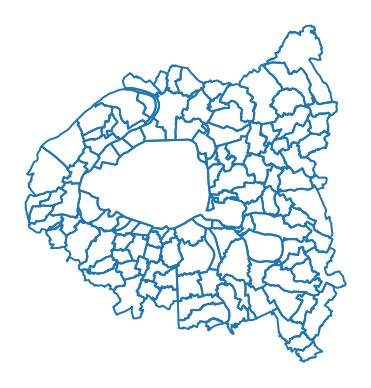

In [7]:
ax = shp_communes.boundary.plot()
ax.set_axis_off()

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Note</h3>

Si on ne désire pas utiliser le niveau `COMMUNE_ARRONDISSEMENT`,
il est nécessaire de mettre en oeuvre une construction du fond de
carte en plusieurs phases.

En premier lieu, il est nécessaire de récupérer le niveau des communes.

``` python
import cartiflette.s3 as s3

shp_communes = s3.download_vectorfile_url_all(
    crs = 4326,
    values = ["75", "92", "93", "94"],
    borders="COMMUNE",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)

shp_communes.head()
```

    https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=75/vectorfile_format='topojson'/provider='IGN'/source='EXPRESS-COG-CARTO-TERRITOIRE'/raw.topojson

    Downloading: : 0.00iB [00:00, ?iB/s]

    Downloading: : 14.5kiB [00:00, 152kiB/s]

    https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=92/vectorfile_format='topojson'/provider='IGN'/source='EXPRESS-COG-CARTO-TERRITOIRE'/raw.topojson

    Downloading: : 0.00iB [00:00, ?iB/s]

    Downloading: : 36.0kiB [00:00, 229kiB/s]

    Downloading: : 62.3kiB [00:00, 343kiB/s]

    https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=93/vectorfile_format='topojson'/provider='IGN'/source='EXPRESS-COG-CARTO-TERRITOIRE'/raw.topojson

    Downloading: : 0.00iB [00:00, ?iB/s]

    Downloading: : 34.0kiB [00:00, 221kiB/s]

    Downloading: : 102kiB [00:00, 411kiB/s] 

    Downloading: : 119kiB [00:00, 437kiB/s]

    https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=94/vectorfile_format='topojson'/provider='IGN'/source='EXPRESS-COG-CARTO-TERRITOIRE'/raw.topojson

    Downloading: : 0.00iB [00:00, ?iB/s]

    Downloading: : 34.0kiB [00:00, 210kiB/s]

    Downloading: : 55.0kiB [00:00, 196kiB/s]

    Downloading: : 110kiB [00:00, 393kiB/s] 

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>

|     | id                       | ID  | NOM              | NOM_M            | INSEE_COM | STATUT          | POPULATION | INSEE_CAN | INSEE_ARR | INSEE_DEP | INSEE_REG | SIREN_EPCI          | source                           | geometry                                          |
|-----|--------------------------|-----|------------------|------------------|-----------|-----------------|------------|-----------|-----------|-----------|-----------|---------------------|----------------------------------|---------------------------------------------------|
| 0   | COMMUNE_0000000009736048 | NaN | Paris            | PARIS            | 75056     | Capitale d'état | 2165423    | NR        | 1         | 75        | 11        | 200054781           | IGN:EXPRESS-COG-CARTO-TERRITOIRE | POLYGON ((2.36421 48.81640, 2.36333 48.81615, ... |
| 0   | COMMUNE_0000000009736037 | NaN | Levallois-Perret | LEVALLOIS-PERRET | 92044     | Commune simple  | 66082      | 16        | 2         | 92        | 11        | 200054781/200057982 | IGN:EXPRESS-COG-CARTO-TERRITOIRE | POLYGON ((2.28739 48.90364, 2.28846 48.90302, ... |
| 1   | COMMUNE_0000000009736055 | NaN | Bois-Colombes    | BOIS-COLOMBES    | 92009     | Commune simple  | 28841      | 11        | 2         | 92        | 11        | 200054781/200057990 | IGN:EXPRESS-COG-CARTO-TERRITOIRE | POLYGON ((2.26639 48.90629, 2.26645 48.90615, ... |
| 2   | COMMUNE_0000000009736538 | NaN | Malakoff         | MALAKOFF         | 92046     | Commune simple  | 30950      | 18        | 1         | 92        | 11        | 200054781/200057966 | IGN:EXPRESS-COG-CARTO-TERRITOIRE | POLYGON ((2.27818 48.81425, 2.28066 48.81469, ... |
| 3   | COMMUNE_0000000009736038 | NaN | Clichy           | CLICHY           | 92024     | Commune simple  | 63089      | 09        | 2         | 92        | 11        | 200054781/200057990 | IGN:EXPRESS-COG-CARTO-TERRITOIRE | POLYGON ((2.30377 48.89415, 2.30258 48.89487, ... |

</div>

``` python
ax = shp_communes.boundary.plot()
ax.set_axis_off()
```

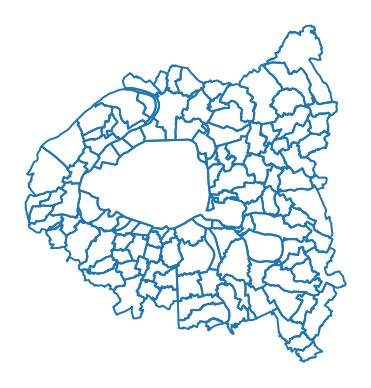

On peut remarquer que la ville de Paris ne comporte pas d’arrondissements
sur cette carte. Pour vous en convaincre, vous pouvez exécuter la
commande :

``` python
ax = shp_communes.loc[shp_communes['INSEE_DEP']=="75"].boundary.plot()
ax.set_axis_off()
```

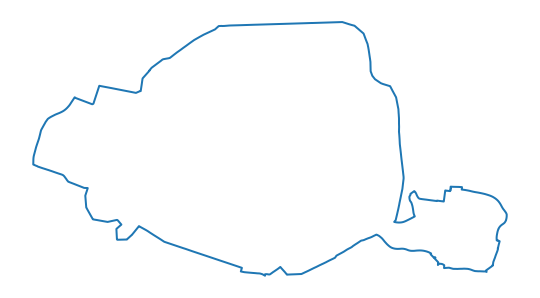

Il faut donc utiliser une source complémentaire.
Le contour officiel des arrondissements est
produit par l’IGN séparemment des contours de communes.
Les contours d’arrondissements sont également
disponibles
grâce à `cartiflette`:

``` python
arrondissements = s3.download_vectorfile_url_all(
    crs = 4326,
    values = ["75"],
    borders="COMMUNE",
    vectorfile_format="topojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022)
```

    https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=75/vectorfile_format='topojson'/provider='IGN'/source='EXPRESS-COG-CARTO-TERRITOIRE'/raw.topojson

    Downloading: : 0.00iB [00:00, ?iB/s]

    Downloading: : 14.5kiB [00:00, 158kiB/s]

``` python
ax = arrondissements.plot(alpha = 0.8, edgecolor = "k")
ax.set_axis_off()
```

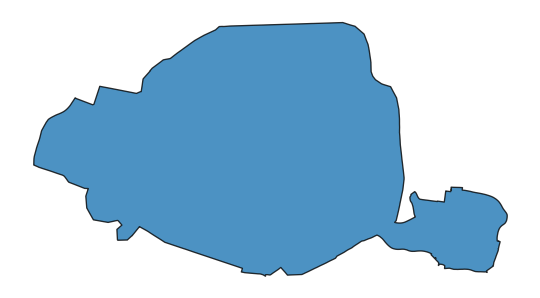

Il ne reste plus qu’à remplacer Paris par
ses arrondissements dans `shp_communes`.
Pour cela, on peut utiliser les méthodes
vues dans le chapitre `Pandas` relatives
aux filtres et à la concaténation
de plusieurs `DataFrames`:

``` python
import pandas as pd

shp_communes = pd.concat(
  [
    shp_communes.loc[shp_communes['INSEE_DEP'] != "75"].to_crs(2154),
    arrondissements.to_crs(2154)
  ])
```

Cette approche fonctionne mais elle nécessite un certain nombre
de gestes, qui sont autant de risques d’erreurs. Il est
donc recommandé de privilégier le niveau `COMMUNE_ARRONDISSEMENT`
qui fait exactement ceci mais de manière fiable.

</div>

# Opérations sur les attributs et les géométries

## Import des données velib

Souvent, le découpage communal ne sert qu’en fond de cartes, pour donner des
repères. En complément de celui-ci, on peut désirer exploiter
un autre jeu de données. On va partir des données de localisation des
stations velib,
disponibles [sur le site d’open data de la ville de Paris](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/table/) et
requêtables directement par l’url
<https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr>

In [14]:
velib_data = 'https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr'
stations = gpd.read_file(velib_data)
stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Les données sont dans le système de projection WGS84 qui est celui du
système GPS. Celui-ci s’intègre bien avec les fonds de carte
`Stamen`, `OpenStreetMap` ou `Google Maps`. En toute rigueur, si on
désire effectuer certains calculs géométriques (mesurer des surfaces…), il est
nécessaire de re-projeter les données dans un système qui préserve la géométrie
(c’est le cas du Lambert 93).

Pour avoir une intuition de la localisation des stations, et notamment de la
densité hétérogène de celles-ci,
on peut afficher les données sur la carte des communes
de la petite couronne. Il s’agit donc d’enrichir la carte
précédente d’une couche supplémentaire, à savoir la localisation
des stations. Au passage, on va utiliser un fond de carte
plus esthétique:

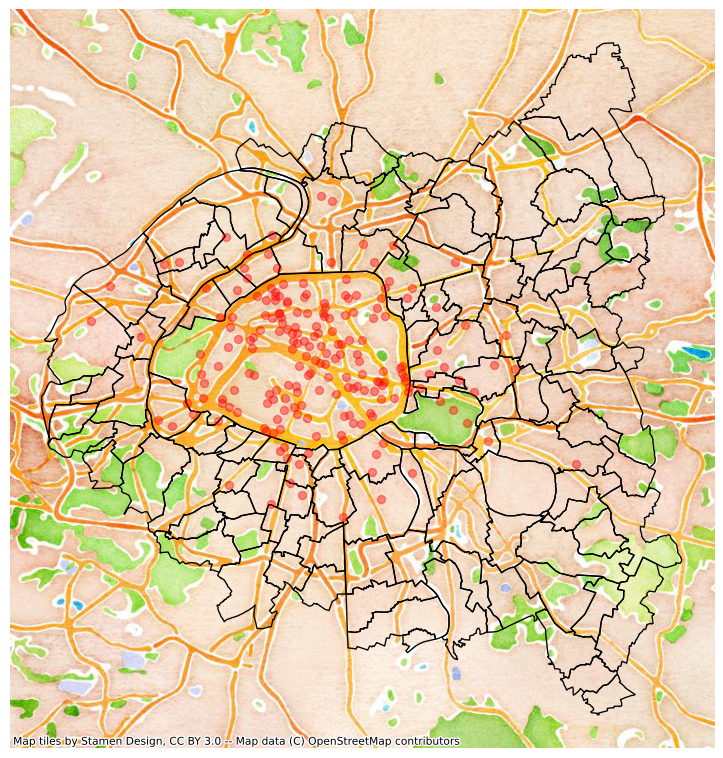

In [15]:
fig,ax = plt.subplots(figsize=(10, 10))
stations.sample(200).to_crs(3857).plot(ax = ax, color = 'red', alpha = 0.4, zorder=2)
shp_communes.to_crs(3857).plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, source = ctx.providers.Stamen.Watercolor)
ax.set_axis_off()

In [16]:
fig = ax.get_figure()
fig.savefig("featured.png")

Découvrez ci-dessous par étape les différentes lignes de commandes permettant d’afficher cette carte complète,
étape par étape :

:one:
Afficher le nuage de points de 200 stations vélibs prises au hasard

<AxesSubplot: >

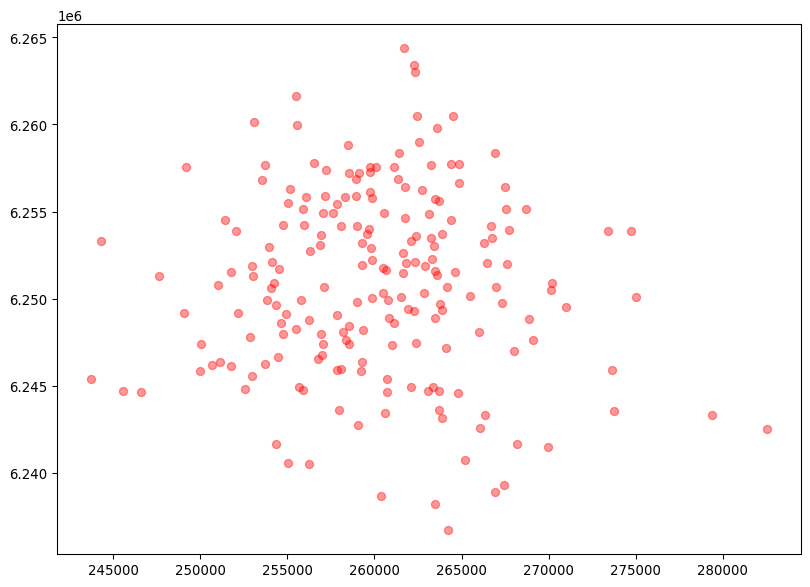

In [17]:
fig,ax = plt.subplots(figsize=(10, 10))
stations.sample(200).to_crs(3857).plot(ax = ax, color = 'red', alpha = 0.4, zorder=2)

:two:
Ajouter à cette couche, en-dessous, les contours des communes

In [18]:
fig,ax = plt.subplots(figsize=(10, 10))
stations.sample(200).to_crs(3857).plot(ax = ax, color = 'red', alpha = 0.4, zorder=2)
shp_communes.to_crs(3857).plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)

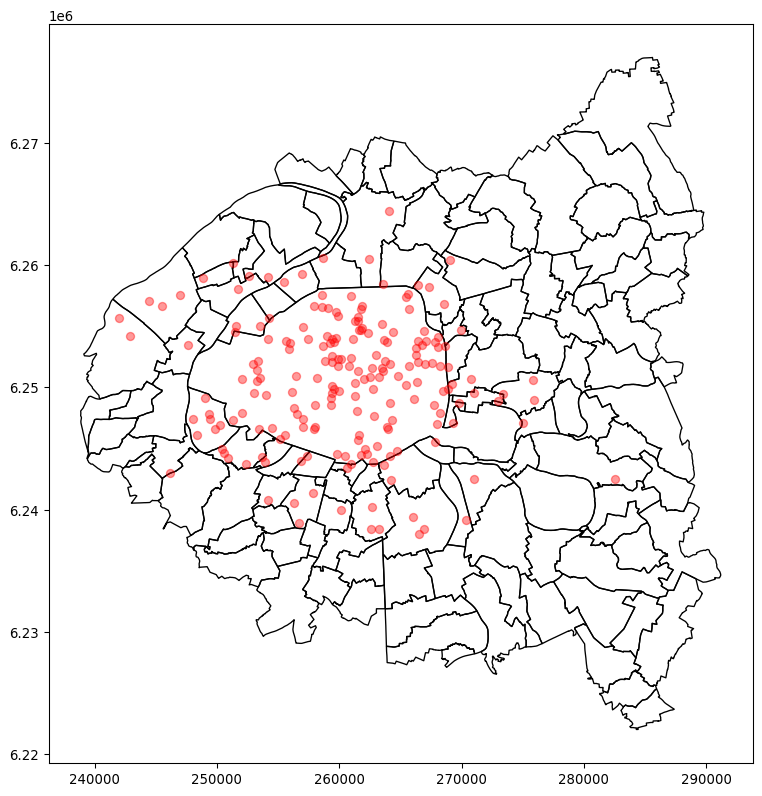

In [19]:
ax.get_figure()

:three:
Ajouter un fond de carte de type *open street map* grâce au package
`contextily`

In [20]:
fig,ax = plt.subplots(figsize=(10, 10))
stations.sample(200).to_crs(3857).plot(ax = ax, color = 'red', alpha = 0.4, zorder=2)
shp_communes.to_crs(3857).plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, source = ctx.providers.Stamen.Watercolor)

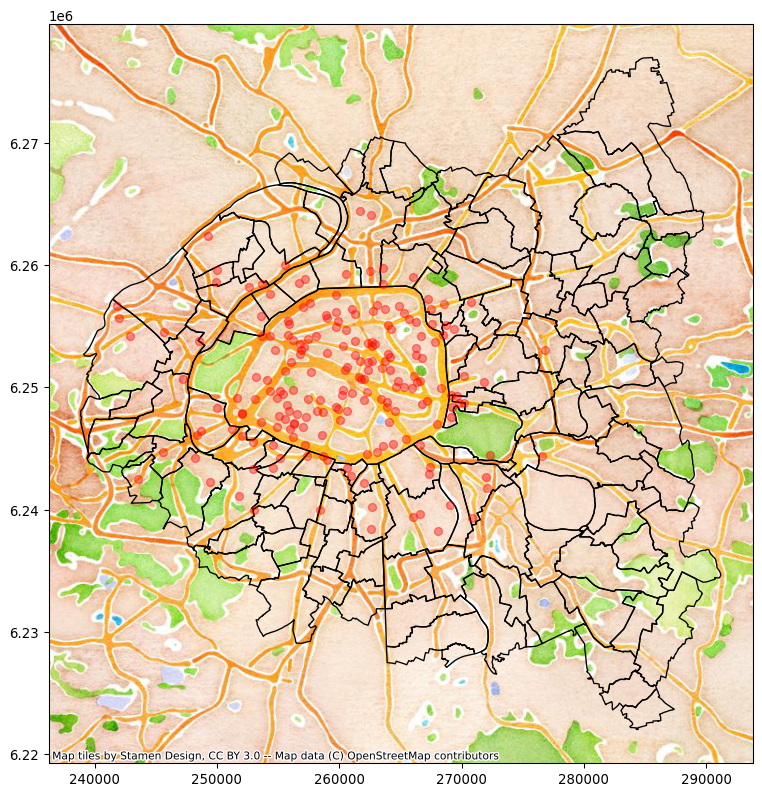

In [21]:
ax.get_figure()

:four:
Il ne reste plus qu’à retirer l’axe des coordonnées, qui n’est pas très
esthétique.

In [22]:
fig,ax = plt.subplots(figsize=(10, 10))
stations.sample(200).to_crs(3857).plot(ax = ax, color = 'red', alpha = 0.4, zorder=2)
shp_communes.to_crs(3857).plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, source = ctx.providers.Stamen.Watercolor)
ax.set_axis_off()
ax

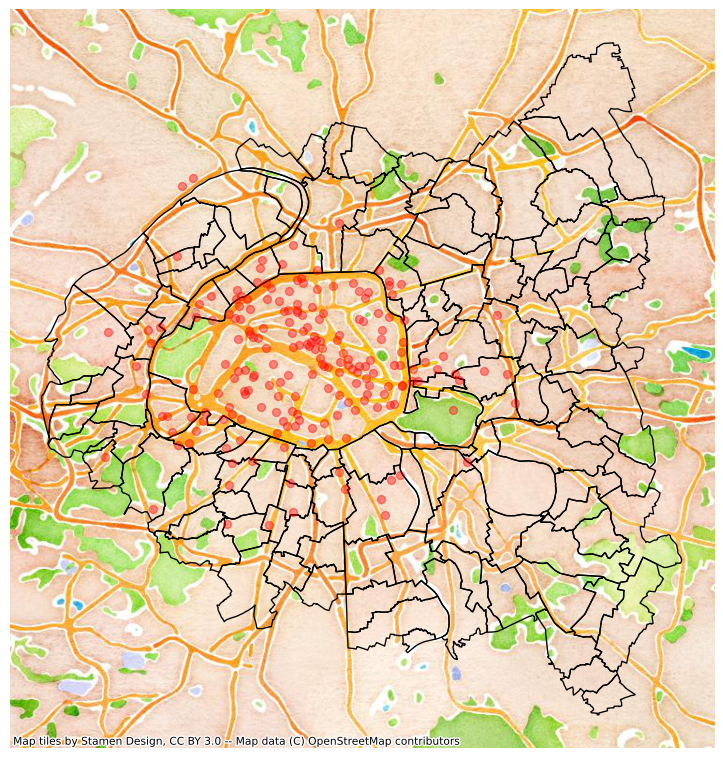

In [23]:
ax.get_figure()

*In fine*, on obtient la carte désirée.

## Opérations sur les attributs

Toutes les opérations possibles sur un objet `Pandas` le sont également
sur un objet `GeoPandas`. Pour manipuler les données, et non la géométrie,
on parlera d’opérations sur les attributs.

Par exemple, si on désire
connaître quelques statistiques sur la taille des stations:

In [24]:
stations.describe()

Pour connaître les plus grands départements de France métropolitaine,
procédons en deux étapes:

1.  Récupérons le contour des communes de France métropolitaine dans son ensemble
    grâce à `cartiflette`.
    Notons qu’on pourrait récupérer directement les contours départementaux mais
    pour l’exercice, nous allons le créer nous-mêmes comme agrégation
    des contours communaux
    (voir [ce notebook `observable`](https://observablehq.com/@linogaliana/cartiflette-demo) pour la méthode plus
    légère qui utilise pleinement les fonctionnalités de `cartiflette`).
2.  Calculons la surface (méthode `area` sur un objet `GeoPandas.GeoDataFrame` ramenée en km², attention néamoins au système de projection comme cela est expliqué plus bas)

In [25]:
from cartiflette.download import get_vectorfile_ign
france = get_vectorfile_ign(
  borders = "COMMUNE",
  field = "metropole",
  source = "EXPRESS-COG-CARTO-TERRITOIRE",
  provider="IGN"
)

In [26]:
france['surface'] = france.area.div(10**6)

Les plus grands départements s’obtiennent par une agrégation des
surfaces communales :

In [27]:
france.groupby('INSEE_DEP').sum(numeric_only = True).sort_values('surface', ascending = False)

96 rows × 2 columns

Si on veut directement les plus
grandes communes de France métropolitaine :

In [28]:
france.sort_values('surface', ascending = False).head(10)

Lors des étapes d’agrégation, `groupby` ne conserve pas les géométries. Autrement
dit, si on effectue, par exemple, une somme en fonction d’une variable de groupe avec
le combo `groupby(...).sum(...)` , on perd
la dimension géographique.

Il est néanmoins possible d’aggréger à la fois les géométries et les
attribus avec la méthode `dissolve`:

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/geopandas/geodataframe.py:1676: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


<AxesSubplot: >

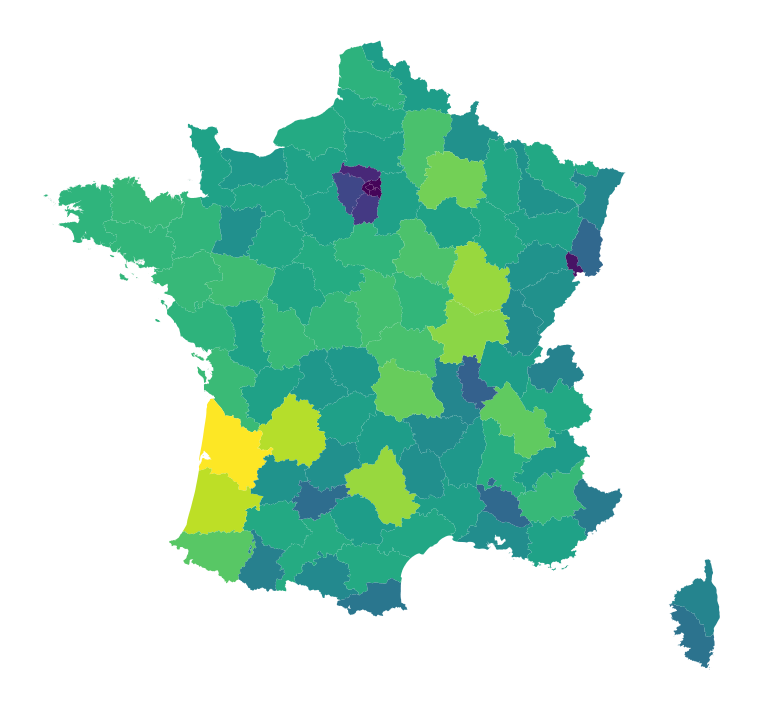

In [29]:
fig,ax = plt.subplots(figsize=(10, 10))
france.dissolve(by='INSEE_DEP', aggfunc='sum').plot(ax = ax, column = "surface")
ax.set_axis_off()
ax

Pour produire cette carte, il serait néanmoins plus simple de directement
récupérer les fonds officiels des départements plutôt que d’agréger les
contours des communes:

https://wxs.ign.fr/x02uy2aiwjo9bm8ce5plwqmr/telechargement/prepackage/ADMINEXPRESS-COG_SHP_TERRITOIRES_PACK_2022-04-15$ADMIN-EXPRESS-COG_3-1__SHP_LAMB93_FXX_2022-04-15/file/ADMIN-EXPRESS-COG_3-1__SHP_LAMB93_FXX_2022-04-15.7z
Data have been previously downloaded and are still available in /tmp/EXPRESS-COG-CARTO-TERRITOIRE-2022/metropole

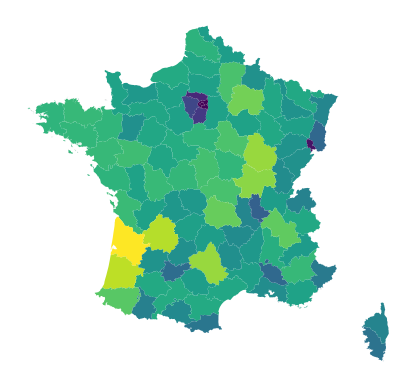

In [30]:
dep = get_vectorfile_ign(
  borders = "DEPARTEMENT", field = "metropole",
  source = "EXPRESS-COG-CARTO-TERRITOIRE", provider="IGN")
dep["area"] = dep.area
ax = dep.plot(column = "area")
ax.set_axis_off()

## Opérations sur les géométries

Outre la représentation graphique simplifiée,
sur laquelle nous reviendrons ultérieurement, l’intérêt principal d’utiliser
`GeoPandas` est l’existence de méthodes efficaces pour
manipuler la dimension spatiale. Un certain nombre proviennent du
package
[`Shapely`](https://shapely.readthedocs.io/en/latest/manual.html#general-attributes-and-methods).

<div class="alert alert-danger" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left: .2rem solid #ff0039;">
<i class="fa fa-exclamation-triangle"></i> Warning</h3>

Les données sont en système de coordonnées WGS 84 ou pseudo-Mercator (epsg: `4326`) et ne sont pas projetées.
C’est un format approprié lorsqu’il s’agit d’utiliser un fonds
de carte `OpenStreetMap`, `Stamen`, `Google Maps`, etc.

Mais ce n’est pas un
format sur lequel on désire faire des calculs car les distances sont faussées sans utiliser de projection. D’ailleurs, `geopandas` refusera certaines opérations
sur des données dont le crs est `4326`. On reprojete ainsi les données
dans la projection officielle pour la métropole, le Lambert 93
(epsg: `2154`).

</div>

Comme indiqué ci-dessus, nous reprojetons les données
dans le système Lambert 93 qui ne fausse pas les
calculs de distance et d’aires.

In [31]:
communes = shp_communes.to_crs(2154)
stations = stations.to_crs(2154)

Par exemple, on peut recalculer la taille d’une commune ou d’arrondissement
avec la méthode `area` (et diviser par $10^6$ pour avoir des $km^2$ au lieu
des $m^2$):

In [32]:
communes['superficie'] = communes.area.div(10**6)
communes.head(3)

Une méthode qu’on utilise régulièrement est `centroid` qui, comme son nom l’indique,
recherche le centroïde de chaque polygone et transforme ainsi des données
surfaciques en données ponctuelles. Par exemple, pour
représenter approximativement les centres des villages de la
Haute-Garonne (31), après avoir téléchargé le fonds de carte adapté,
fera

https://minio.lab.sspcloud.fr/projet-cartiflette/diffusion/shapefiles-test1/year=2022/administrative_level=COMMUNE/crs=4326/DEPARTEMENT=31/vectorfile_format='topojson'/provider='IGN'/source='EXPRESS-COG-CARTO-TERRITOIRE'/raw.topojson

Downloading: : 0.00iB [00:00, ?iB/s]

Downloading: : 38.0kiB [00:00, 206kiB/s]

Downloading: : 122kiB [00:00, 269kiB/s] 

Downloading: : 230kiB [00:00, 437kiB/s]

Downloading: : 280kiB [00:00, 409kiB/s]

Downloading: : 338kiB [00:00, 414kiB/s]

Downloading: : 382kiB [00:01, 382kiB/s]

Downloading: : 454kiB [00:01, 425kiB/s]

Downloading: : 502kiB [00:01, 399kiB/s]

Downloading: : 578kiB [00:01, 445kiB/s]

Downloading: : 634kiB [00:01, 430kiB/s]

Downloading: : 706kiB [00:01, 461kiB/s]

Downloading: : 766kiB [00:01, 448kiB/s]

Downloading: : 838kiB [00:02, 473kiB/s]

Downloading: : 898kiB [00:02, 462kiB/s]

Downloading: : 950kiB [00:02, 477kiB/s]

Downloading: : 0.99MiB [00:02, 485kiB/s]

Downloading: : 1.05MiB [00:02, 472kiB/s]

Downloading: : 1.11MiB [00:02, 493kiB/s]

Downloading: : 1.17MiB [00:02, 497kiB/s]

Downloading: : 1.23MiB [00:02, 479kiB/s]

Downloading: : 1.29MiB [00:03, 511kiB/s]

Downloading: : 1.36MiB [00:03, 507kiB/s]

Downloading: : 1.43MiB [00:03, 524kiB/s]

Downloading: : 1.49MiB [00:03, 551kiB/s]

Downloading: : 1.56MiB [00:03, 529kiB/s]

Downloading: : 1.60MiB [00:03, 464kiB/s]

<AxesSubplot: >

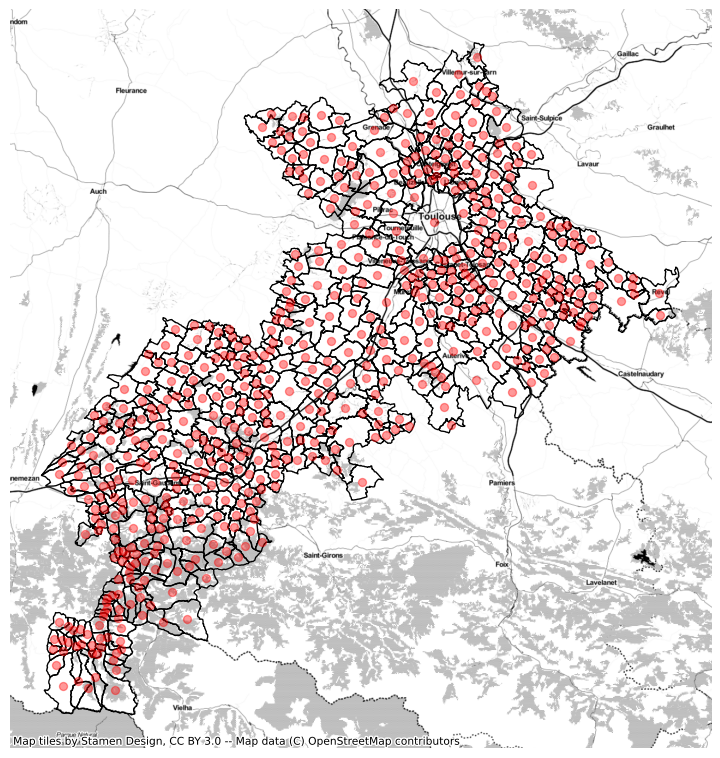

In [33]:
communes_31 = s3.download_vectorfile_url_all(
      crs = 4326,
      values = "31",
      borders="COMMUNE",
      vectorfile_format="topojson",
      filter_by="DEPARTEMENT",
      source="EXPRESS-COG-CARTO-TERRITOIRE",
      year=2022)

# on reprojete en 3857 pour le fond de carte
communes_31 = communes_31.to_crs(3857)

# on calcule le centroide
dep_31 = communes_31.copy()
communes_31['geometry'] = communes_31['geometry'].centroid

ax = communes_31.plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
dep_31.to_crs(3857).plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, source = ctx.providers.Stamen.Toner)
ax.set_axis_off()
ax

# Gérer le système de projection

Précédemment, nous avons appliqué une méthode `to_crs` pour reprojeter
les données dans un système de projection différent de celui du fichier
d’origine :

In [34]:
communes = communes.to_crs(2154)
stations = stations.to_crs(2154)

Le système de projection est fondamental pour que la dimension
spatiale soit bien interprétée par `Python`. Un mauvais système de représentation
fausse l’appréciation visuelle mais peut aussi entraîner des erreurs dans
les calculs sur la dimension spatiale.
Ce [post](https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/geographic-vs-projected-coordinate-reference-systems-UTM/) propose de riches éléments sur le
sujet, notamment l’image suivante qui montre bien le principe d’une projection :

![Les différents types de projection](https://www.earthdatascience.org/images/courses/earth-analytics/spatial-data/spatial-projection-transformations-crs.png)

La Terre peut ainsi être représentée de multiples manières, ce qui n’est pas neutre sur la manière de se représenter
certains continents.
L’Afrique apparaît beaucoup moins vaste qu’elle ne l’est en réalité sur les cartes utilisant
cette projection.
L’une des déformations les mieux connue est celle provoquée par la projection Mercator.
Le Groënland paraît avoir
la même surface que l’Amérique du Sud. Pourtant, cette dernière est 8 fois
plus grande.

Il existe en fait de nombreuses représentations possibles du monde, plus ou moins
alambiquées. Les projections sont très nombreuses et certaines peuvent avoir une [forme suprenante](https://imgs.xkcd.com/comics/map_projections.png).
Par exemple,
la [projection de Spillhaus](https://storymaps.arcgis.com/stories/756bcae18d304a1eac140f19f4d5cb3d)
propose de centrer la vue sur les océans et non une terre. C’est pour
cette raison qu’on parle parfois de monde tel que vu par les poissons
à son propos.

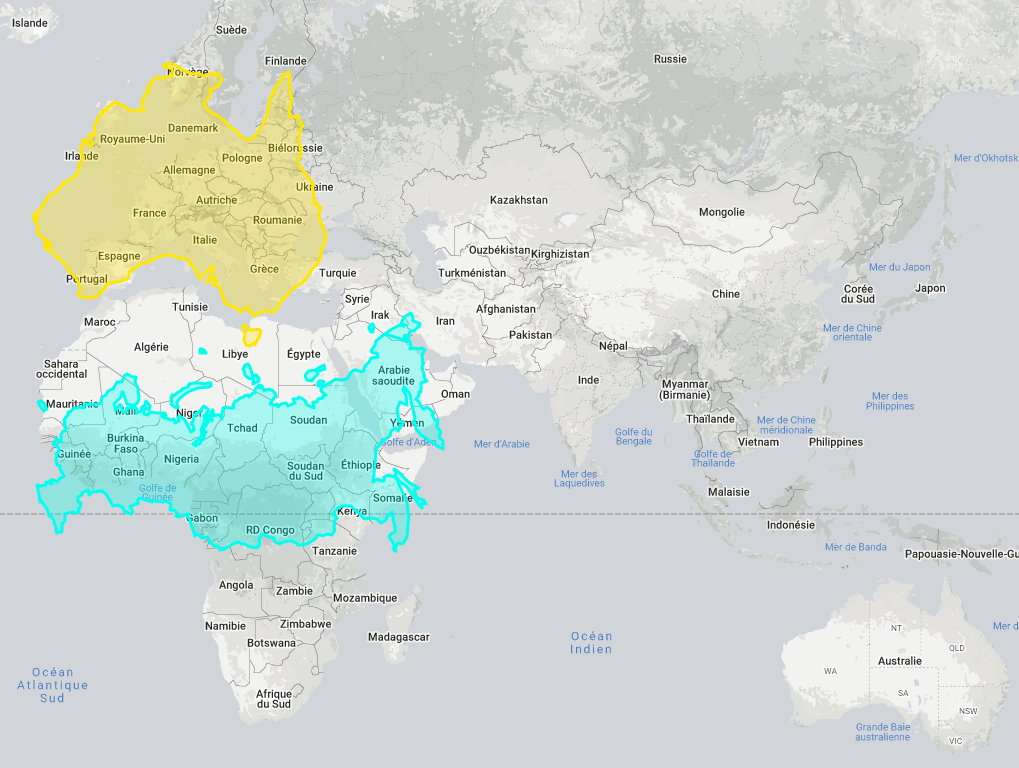
*Exemple de reprojection de pays depuis le site [thetruesize.com](https://thetruesize.com/)*

Concernant la gestion des projections avec `GeoPandas`,
la [documentation officielle](https://geopandas.org/projections.html) est très bien
faite. Elle fournit notamment l’avertissement suivant qu’il est
bon d’avoir en tête:

> Be aware that most of the time you don’t have to set a projection. Data loaded from a reputable source (using the geopandas.read_file() command) should always include projection information. You can see an objects current CRS through the GeoSeries.crs attribute.
>
> From time to time, however, you may get data that does not include a projection. In this situation, you have to set the CRS so geopandas knows how to interpret the coordinates.

![](https://imgs.xkcd.com/comics/bad_map_projection_south_america.png)
*Image empruntée à XKCD <https://xkcd.com/2256/> qu’on peut également trouver sur <https://blog.chrislansdown.com/2020/01/17/a-great-map-projection-joke/>*

Pour déterminer le système de projection d’une base de données, on peut vérifier l’attribut `crs`:

In [35]:
communes.crs

<Derived Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Les deux principales méthodes pour définir le système de projection utilisé sont:

-   **`df.set_crs`**: cette commande sert à préciser quel est le système de projection utilisé, c’est-à-dire comment les coordonnées *(x,y)* sont reliées à la surface terrestre. **Cette commande ne doit pas être utilisée pour transformer le système de coordonnées, seulement pour le définir**.
-   **`df.to_crs`**: **cette commande sert à projeter les points d’une géométrie dans une autre, c’est-à-dire à recalculer les coordonnées selon un autre système de projection.**

Dans le cas particulier de production de carte avec un fond `OpenStreetMaps` ou une carte dynamique `leaflet`, il est nécessaire de dé-projeter les données (par exemple à partir du Lambert-93) pour atterrir dans le système non-projeté WGS 84 (code EPSG 4326). Ce site [dédié aux projections géographiques](https://epsg.io/) peut-être utile pour retrouver le système de projection d’un fichier où il n’est pas indiqué.

La définition du système de projection se fait de la manière suivante (:warning: avant de le faire, se souvenir de l’avertissement !):

``` python
communes = communes.set_crs(2154)
```

Alors que la reprojection (projection Albers : `5070`) s’obtient de la manière suivante :

http://files.opendatarchives.fr/professionnels.ign.fr/adminexpress/ADMIN-EXPRESS-COG_3-1__SHP__FRA_L93_2022-04-15.7z

Downloading: : 0.00iB [00:00, ?iB/s]

Downloading: : 15.0kiB [00:00, 75.8kiB/s]

Downloading: : 29.0kiB [00:00, 97.4kiB/s]

Downloading: : 68.0kiB [00:00, 109kiB/s] 

Downloading: : 138kiB [00:00, 235kiB/s] 

Downloading: : 171kiB [00:01, 151kiB/s]

Downloading: : 195kiB [00:01, 144kiB/s]

Downloading: : 244kiB [00:01, 159kiB/s]

Downloading: : 305kiB [00:01, 189kiB/s]

Downloading: : 339kiB [00:02, 181kiB/s]

Downloading: : 372kiB [00:02, 184kiB/s]

Downloading: : 409kiB [00:02, 178kiB/s]

Downloading: : 428kiB [00:02, 158kiB/s]

Downloading: : 474kiB [00:02, 186kiB/s]

Downloading: : 516kiB [00:03, 180kiB/s]

Downloading: : 558kiB [00:03, 220kiB/s]

Downloading: : 583kiB [00:03, 149kiB/s]

Downloading: : 630kiB [00:03, 199kiB/s]

Downloading: : 658kiB [00:04, 149kiB/s]

Downloading: : 700kiB [00:04, 162kiB/s]

Downloading: : 729kiB [00:04, 165kiB/s]

Downloading: : 754kiB [00:04, 178kiB/s]

Downloading: : 786kiB [00:04, 169kiB/s]

Downloading: : 827kiB [00:05, 172kiB/s]

Downloading: : 856kiB [00:05, 178kiB/s]

Downloading: : 892kiB [00:05, 178kiB/s]

Downloading: : 931kiB [00:05, 218kiB/s]

Downloading: : 956kiB [00:05, 180kiB/s]

Downloading: : 982kiB [00:05, 166kiB/s]

Downloading: : 0.98MiB [00:06, 165kiB/s]

Downloading: : 1.02MiB [00:06, 175kiB/s]

Downloading: : 1.07MiB [00:06, 180kiB/s]

Downloading: : 1.09MiB [00:06, 188kiB/s]

Downloading: : 1.12MiB [00:06, 173kiB/s]

Downloading: : 1.14MiB [00:06, 175kiB/s]

Downloading: : 1.17MiB [00:07, 137kiB/s]

Downloading: : 1.22MiB [00:07, 177kiB/s]

Downloading: : 1.27MiB [00:07, 229kiB/s]

Downloading: : 1.30MiB [00:07, 193kiB/s]

Downloading: : 1.34MiB [00:07, 202kiB/s]

Downloading: : 1.37MiB [00:08, 227kiB/s]

Downloading: : 1.42MiB [00:08, 289kiB/s]

Downloading: : 1.46MiB [00:08, 250kiB/s]

Downloading: : 1.50MiB [00:08, 244kiB/s]

Downloading: : 1.57MiB [00:08, 339kiB/s]

Downloading: : 1.61MiB [00:08, 289kiB/s]

Downloading: : 1.64MiB [00:09, 292kiB/s]

Downloading: : 1.69MiB [00:09, 306kiB/s]

Downloading: : 1.72MiB [00:09, 283kiB/s]

Downloading: : 1.76MiB [00:09, 284kiB/s]

Downloading: : 1.89MiB [00:09, 523kiB/s]

Downloading: : 1.95MiB [00:09, 508kiB/s]

Downloading: : 2.00MiB [00:09, 490kiB/s]

Downloading: : 2.05MiB [00:09, 506kiB/s]

Downloading: : 2.12MiB [00:10, 540kiB/s]

Downloading: : 2.19MiB [00:10, 595kiB/s]

Downloading: : 2.27MiB [00:10, 669kiB/s]

Downloading: : 2.35MiB [00:10, 583kiB/s]

Downloading: : 2.49MiB [00:10, 688kiB/s]

Downloading: : 2.59MiB [00:10, 768kiB/s]

Downloading: : 2.68MiB [00:10, 643kiB/s]

Downloading: : 2.74MiB [00:10, 640kiB/s]

Downloading: : 2.97MiB [00:11, 936kiB/s]

Downloading: : 3.06MiB [00:11, 831kiB/s]

Downloading: : 3.24MiB [00:11, 844kiB/s]

Downloading: : 3.48MiB [00:11, 1.11MiB/s]

Downloading: : 3.59MiB [00:11, 982kiB/s] 

Downloading: : 3.75MiB [00:12, 816kiB/s]

Downloading: : 4.06MiB [00:12, 1.24MiB/s]

Downloading: : 4.21MiB [00:12, 980kiB/s] 

Downloading: : 4.33MiB [00:12, 935kiB/s]

Downloading: : 4.53MiB [00:12, 1.06MiB/s]

Downloading: : 4.65MiB [00:12, 1.08MiB/s]

Downloading: : 4.98MiB [00:12, 1.59MiB/s]

Downloading: : 5.16MiB [00:13, 1.31MiB/s]

Downloading: : 5.31MiB [00:13, 1.36MiB/s]

Downloading: : 5.46MiB [00:13, 1.15MiB/s]

Downloading: : 5.70MiB [00:13, 1.23MiB/s]

Downloading: : 6.00MiB [00:13, 1.35MiB/s]

Downloading: : 6.30MiB [00:13, 1.70MiB/s]

Downloading: : 6.62MiB [00:14, 2.07MiB/s]

Downloading: : 6.85MiB [00:14, 1.81MiB/s]

Downloading: : 7.05MiB [00:14, 1.64MiB/s]

Downloading: : 7.23MiB [00:14, 1.62MiB/s]

Downloading: : 7.45MiB [00:14, 1.66MiB/s]

Downloading: : 7.68MiB [00:14, 1.70MiB/s]

Downloading: : 7.90MiB [00:14, 1.74MiB/s]

Downloading: : 8.09MiB [00:15, 1.25MiB/s]

Downloading: : 8.31MiB [00:15, 1.38MiB/s]

Downloading: : 8.94MiB [00:15, 1.93MiB/s]

Downloading: : 9.13MiB [00:15, 1.77MiB/s]

Downloading: : 9.46MiB [00:15, 2.02MiB/s]

Downloading: : 9.75MiB [00:15, 2.09MiB/s]

Downloading: : 10.1MiB [00:16, 2.10MiB/s]

Downloading: : 10.3MiB [00:16, 2.13MiB/s]

Downloading: : 10.5MiB [00:16, 2.11MiB/s]

Downloading: : 10.8MiB [00:16, 2.18MiB/s]

Downloading: : 11.3MiB [00:16, 2.65MiB/s]

Downloading: : 11.5MiB [00:16, 2.61MiB/s]

Downloading: : 11.8MiB [00:16, 2.48MiB/s]

Downloading: : 12.0MiB [00:16, 2.20MiB/s]

Downloading: : 12.3MiB [00:17, 1.71MiB/s]

Downloading: : 12.6MiB [00:17, 1.94MiB/s]

Downloading: : 13.3MiB [00:17, 3.06MiB/s]

Downloading: : 13.6MiB [00:17, 2.57MiB/s]

Downloading: : 13.9MiB [00:17, 2.58MiB/s]

Downloading: : 14.3MiB [00:17, 2.60MiB/s]

Downloading: : 14.8MiB [00:18, 2.74MiB/s]

Downloading: : 15.4MiB [00:18, 3.31MiB/s]

Downloading: : 15.7MiB [00:18, 3.28MiB/s]

Downloading: : 16.0MiB [00:18, 3.21MiB/s]

Downloading: : 16.4MiB [00:18, 3.15MiB/s]

Downloading: : 16.8MiB [00:18, 2.65MiB/s]

Downloading: : 17.1MiB [00:18, 2.33MiB/s]

Downloading: : 17.9MiB [00:19, 3.67MiB/s]

Downloading: : 18.4MiB [00:19, 3.71MiB/s]

Downloading: : 18.8MiB [00:19, 2.97MiB/s]

Downloading: : 19.2MiB [00:19, 3.20MiB/s]

Downloading: : 20.2MiB [00:19, 4.79MiB/s]

Downloading: : 20.7MiB [00:19, 4.64MiB/s]

Downloading: : 21.2MiB [00:20, 3.20MiB/s]

Downloading: : 21.6MiB [00:20, 2.52MiB/s]

Downloading: : 22.0MiB [00:20, 2.31MiB/s]

Downloading: : 22.3MiB [00:20, 2.27MiB/s]

Downloading: : 22.9MiB [00:20, 2.77MiB/s]

Downloading: : 23.6MiB [00:20, 3.65MiB/s]

Downloading: : 24.0MiB [00:21, 3.80MiB/s]

Downloading: : 24.6MiB [00:21, 4.02MiB/s]

Downloading: : 25.0MiB [00:21, 2.87MiB/s]

Downloading: : 25.4MiB [00:21, 3.00MiB/s]

Downloading: : 26.2MiB [00:21, 3.88MiB/s]

Downloading: : 27.0MiB [00:21, 4.63MiB/s]

Downloading: : 27.5MiB [00:21, 4.32MiB/s]

Downloading: : 28.4MiB [00:22, 5.68MiB/s]

Downloading: : 29.0MiB [00:22, 5.52MiB/s]

Downloading: : 29.6MiB [00:22, 5.40MiB/s]

Downloading: : 30.2MiB [00:22, 3.79MiB/s]

Downloading: : 30.6MiB [00:22, 3.37MiB/s]

Downloading: : 31.0MiB [00:22, 3.44MiB/s]

Downloading: : 31.8MiB [00:23, 3.61MiB/s]

Downloading: : 32.4MiB [00:23, 3.83MiB/s]

Downloading: : 33.7MiB [00:23, 5.58MiB/s]

Downloading: : 34.6MiB [00:23, 6.43MiB/s]

Downloading: : 35.3MiB [00:23, 6.09MiB/s]

Downloading: : 35.9MiB [00:23, 6.00MiB/s]

Downloading: : 36.6MiB [00:23, 6.21MiB/s]

Downloading: : 37.3MiB [00:23, 5.37MiB/s]

Downloading: : 37.8MiB [00:24, 5.40MiB/s]

Downloading: : 38.9MiB [00:24, 6.46MiB/s]

Downloading: : 39.5MiB [00:24, 4.83MiB/s]

Downloading: : 40.6MiB [00:24, 5.30MiB/s]

Downloading: : 42.5MiB [00:24, 7.94MiB/s]

Downloading: : 43.4MiB [00:24, 6.71MiB/s]

Downloading: : 44.1MiB [00:25, 6.68MiB/s]

Downloading: : 45.4MiB [00:25, 8.18MiB/s]

Downloading: : 46.3MiB [00:25, 5.37MiB/s]

Downloading: : 48.0MiB [00:25, 7.33MiB/s]

Downloading: : 48.9MiB [00:25, 6.59MiB/s]

Downloading: : 49.7MiB [00:25, 6.70MiB/s]

Downloading: : 50.4MiB [00:26, 5.94MiB/s]

Downloading: : 51.7MiB [00:26, 7.24MiB/s]

Downloading: : 52.8MiB [00:26, 7.13MiB/s]

Downloading: : 53.5MiB [00:26, 6.89MiB/s]

Downloading: : 54.2MiB [00:26, 5.88MiB/s]

Downloading: : 56.4MiB [00:26, 8.81MiB/s]

Downloading: : 57.3MiB [00:27, 5.95MiB/s]

Downloading: : 59.6MiB [00:27, 9.04MiB/s]

Downloading: : 60.7MiB [00:27, 7.31MiB/s]

Downloading: : 61.8MiB [00:27, 7.96MiB/s]

Downloading: : 62.8MiB [00:27, 8.23MiB/s]

Downloading: : 63.7MiB [00:27, 7.22MiB/s]

Downloading: : 64.5MiB [00:28, 7.27MiB/s]

Downloading: : 66.6MiB [00:28, 8.72MiB/s]

Downloading: : 67.5MiB [00:28, 8.83MiB/s]

Downloading: : 68.4MiB [00:28, 8.81MiB/s]

Downloading: : 69.3MiB [00:28, 8.52MiB/s]

Downloading: : 70.1MiB [00:28, 7.35MiB/s]

Downloading: : 71.2MiB [00:28, 8.22MiB/s]

Downloading: : 72.1MiB [00:29, 7.10MiB/s]

Downloading: : 74.4MiB [00:29, 11.3MiB/s]

Downloading: : 75.7MiB [00:29, 7.39MiB/s]

Downloading: : 76.6MiB [00:29, 7.23MiB/s]

Downloading: : 78.5MiB [00:29, 8.25MiB/s]

Downloading: : 79.4MiB [00:30, 6.60MiB/s]

Downloading: : 81.2MiB [00:30, 8.08MiB/s]

Downloading: : 83.0MiB [00:30, 10.1MiB/s]

Downloading: : 84.1MiB [00:30, 10.5MiB/s]

Downloading: : 85.4MiB [00:30, 11.0MiB/s]

Downloading: : 86.6MiB [00:30, 11.4MiB/s]

Downloading: : 87.8MiB [00:30, 11.7MiB/s]

Downloading: : 89.0MiB [00:30, 8.77MiB/s]

Downloading: : 91.2MiB [00:31, 11.1MiB/s]

Downloading: : 92.4MiB [00:31, 7.43MiB/s]

Downloading: : 94.0MiB [00:31, 7.76MiB/s]

Downloading: : 95.3MiB [00:31, 8.30MiB/s]

Downloading: : 96.2MiB [00:31, 6.83MiB/s]

Downloading: : 97.3MiB [00:32, 7.52MiB/s]

Downloading: : 98.2MiB [00:32, 5.97MiB/s]

Downloading: : 98.8MiB [00:32, 5.85MiB/s]

Downloading: : 101MiB [00:32, 7.33MiB/s] 

Downloading: : 101MiB [00:32, 5.81MiB/s]

Downloading: : 103MiB [00:32, 6.57MiB/s]

Downloading: : 104MiB [00:33, 7.73MiB/s]

Downloading: : 105MiB [00:33, 7.21MiB/s]

Downloading: : 105MiB [00:33, 5.75MiB/s]

Downloading: : 106MiB [00:33, 5.23MiB/s]

Downloading: : 107MiB [00:33, 6.34MiB/s]

Downloading: : 108MiB [00:33, 6.97MiB/s]

Downloading: : 109MiB [00:34, 6.30MiB/s]

Downloading: : 109MiB [00:34, 6.54MiB/s]

Downloading: : 110MiB [00:34, 6.87MiB/s]

Downloading: : 111MiB [00:34, 6.09MiB/s]

Downloading: : 112MiB [00:34, 6.89MiB/s]

Downloading: : 113MiB [00:34, 7.11MiB/s]

Downloading: : 114MiB [00:34, 7.55MiB/s]

Downloading: : 115MiB [00:34, 7.74MiB/s]

Downloading: : 116MiB [00:35, 8.12MiB/s]

Downloading: : 117MiB [00:35, 8.62MiB/s]

Downloading: : 118MiB [00:35, 6.76MiB/s]

Downloading: : 119MiB [00:35, 6.62MiB/s]

Downloading: : 120MiB [00:35, 5.91MiB/s]

Downloading: : 120MiB [00:35, 4.54MiB/s]

Downloading: : 121MiB [00:36, 4.38MiB/s]

Downloading: : 121MiB [00:36, 4.57MiB/s]

Downloading: : 122MiB [00:36, 5.43MiB/s]

Downloading: : 123MiB [00:36, 4.21MiB/s]

Downloading: : 124MiB [00:36, 4.89MiB/s]

Downloading: : 124MiB [00:36, 4.15MiB/s]

Downloading: : 125MiB [00:37, 3.58MiB/s]

Downloading: : 126MiB [00:37, 4.53MiB/s]

Downloading: : 127MiB [00:37, 4.22MiB/s]

Downloading: : 127MiB [00:37, 4.44MiB/s]

Downloading: : 128MiB [00:37, 3.73MiB/s]

Downloading: : 129MiB [00:37, 5.16MiB/s]

Downloading: : 129MiB [00:38, 4.94MiB/s]

Downloading: : 130MiB [00:38, 3.75MiB/s]

Downloading: : 131MiB [00:38, 4.64MiB/s]

Downloading: : 132MiB [00:38, 4.88MiB/s]

Downloading: : 132MiB [00:38, 3.91MiB/s]

Downloading: : 133MiB [00:38, 3.98MiB/s]

Downloading: : 134MiB [00:39, 3.85MiB/s]

Downloading: : 135MiB [00:39, 4.32MiB/s]

Downloading: : 136MiB [00:39, 4.78MiB/s]

Downloading: : 136MiB [00:39, 4.58MiB/s]

Downloading: : 137MiB [00:40, 3.39MiB/s]

Downloading: : 137MiB [00:40, 3.21MiB/s]

Downloading: : 138MiB [00:40, 4.47MiB/s]

Downloading: : 139MiB [00:40, 4.02MiB/s]

Downloading: : 139MiB [00:40, 3.35MiB/s]

Downloading: : 140MiB [00:40, 3.80MiB/s]

Downloading: : 140MiB [00:41, 3.23MiB/s]

Downloading: : 141MiB [00:41, 3.41MiB/s]

Downloading: : 141MiB [00:41, 3.50MiB/s]

Downloading: : 142MiB [00:41, 3.07MiB/s]

Downloading: : 143MiB [00:41, 2.92MiB/s]

Downloading: : 144MiB [00:42, 4.51MiB/s]

Downloading: : 145MiB [00:42, 4.59MiB/s]

Downloading: : 145MiB [00:42, 4.13MiB/s]

Downloading: : 146MiB [00:42, 4.12MiB/s]

Downloading: : 146MiB [00:42, 4.15MiB/s]

Downloading: : 147MiB [00:42, 3.84MiB/s]

Downloading: : 147MiB [00:42, 3.53MiB/s]

Downloading: : 147MiB [00:42, 3.73MiB/s]

Downloading: : 148MiB [00:43, 4.37MiB/s]

Downloading: : 148MiB [00:43, 4.33MiB/s]

Downloading: : 149MiB [00:43, 3.39MiB/s]

Downloading: : 150MiB [00:43, 4.24MiB/s]

Downloading: : 150MiB [00:43, 3.59MiB/s]

Downloading: : 151MiB [00:43, 3.09MiB/s]

Downloading: : 151MiB [00:44, 2.93MiB/s]

Downloading: : 151MiB [00:44, 2.57MiB/s]

Downloading: : 152MiB [00:44, 2.45MiB/s]

Downloading: : 152MiB [00:44, 2.78MiB/s]

Downloading: : 152MiB [00:44, 2.21MiB/s]

Downloading: : 154MiB [00:44, 4.16MiB/s]

Downloading: : 154MiB [00:45, 3.64MiB/s]

Downloading: : 155MiB [00:45, 4.02MiB/s]

Downloading: : 156MiB [00:45, 6.97MiB/s]

Downloading: : 157MiB [00:45, 5.54MiB/s]

Downloading: : 158MiB [00:45, 5.51MiB/s]

Downloading: : 158MiB [00:45, 4.77MiB/s]

Downloading: : 159MiB [00:45, 5.01MiB/s]

Downloading: : 160MiB [00:46, 4.41MiB/s]

Downloading: : 161MiB [00:46, 5.45MiB/s]

Downloading: : 161MiB [00:46, 4.64MiB/s]

Downloading: : 163MiB [00:46, 6.11MiB/s]

Downloading: : 163MiB [00:46, 6.26MiB/s]

Downloading: : 164MiB [00:46, 7.39MiB/s]

Downloading: : 165MiB [00:47, 5.95MiB/s]

Downloading: : 166MiB [00:47, 4.69MiB/s]

Downloading: : 168MiB [00:47, 8.03MiB/s]

Downloading: : 169MiB [00:47, 6.28MiB/s]

Downloading: : 170MiB [00:47, 6.51MiB/s]

Downloading: : 170MiB [00:47, 5.58MiB/s]

Downloading: : 173MiB [00:48, 8.78MiB/s]

Downloading: : 174MiB [00:48, 6.66MiB/s]

Downloading: : 175MiB [00:48, 6.37MiB/s]

Downloading: : 175MiB [00:48, 6.56MiB/s]

Downloading: : 176MiB [00:48, 6.48MiB/s]

Downloading: : 177MiB [00:48, 8.31MiB/s]

Downloading: : 178MiB [00:49, 5.99MiB/s]

Downloading: : 180MiB [00:49, 7.87MiB/s]

Downloading: : 181MiB [00:49, 6.00MiB/s]

Downloading: : 183MiB [00:49, 7.29MiB/s]

Downloading: : 184MiB [00:49, 9.27MiB/s]

Downloading: : 185MiB [00:50, 6.85MiB/s]

Downloading: : 186MiB [00:50, 6.84MiB/s]

Downloading: : 187MiB [00:50, 7.11MiB/s]

Downloading: : 188MiB [00:50, 6.11MiB/s]

Downloading: : 190MiB [00:50, 7.67MiB/s]

Downloading: : 191MiB [00:50, 7.98MiB/s]

Downloading: : 192MiB [00:50, 8.64MiB/s]

Downloading: : 192MiB [00:51, 5.55MiB/s]

Downloading: : 195MiB [00:51, 9.14MiB/s]

Downloading: : 196MiB [00:52, 3.53MiB/s]

Downloading: : 197MiB [00:52, 3.46MiB/s]

Downloading: : 198MiB [00:52, 3.22MiB/s]

Downloading: : 198MiB [00:53, 3.50MiB/s]

Downloading: : 199MiB [00:53, 3.59MiB/s]

Downloading: : 200MiB [00:53, 3.31MiB/s]

Downloading: : 200MiB [00:53, 3.04MiB/s]

Downloading: : 201MiB [00:53, 3.72MiB/s]

Downloading: : 201MiB [00:53, 3.13MiB/s]

Downloading: : 202MiB [00:54, 3.13MiB/s]

Downloading: : 202MiB [00:54, 3.13MiB/s]

Downloading: : 203MiB [00:54, 3.00MiB/s]

Downloading: : 203MiB [00:54, 3.10MiB/s]

Downloading: : 203MiB [00:54, 3.00MiB/s]

Downloading: : 204MiB [00:54, 3.10MiB/s]

Downloading: : 204MiB [00:54, 2.76MiB/s]

Downloading: : 204MiB [00:55, 3.25MiB/s]

Downloading: : 205MiB [00:55, 3.79MiB/s]

Downloading: : 206MiB [00:55, 3.15MiB/s]

Downloading: : 206MiB [00:55, 3.04MiB/s]

Downloading: : 206MiB [00:55, 2.76MiB/s]

Downloading: : 207MiB [00:55, 3.73MiB/s]

Downloading: : 207MiB [00:56, 2.99MiB/s]

Downloading: : 208MiB [00:56, 3.00MiB/s]

Downloading: : 208MiB [00:56, 2.60MiB/s]

Downloading: : 209MiB [00:56, 3.23MiB/s]

Downloading: : 209MiB [00:56, 3.17MiB/s]

Downloading: : 210MiB [00:56, 3.20MiB/s]

Downloading: : 210MiB [00:57, 3.21MiB/s]

Downloading: : 211MiB [00:57, 3.17MiB/s]

Downloading: : 211MiB [00:57, 3.30MiB/s]

Downloading: : 211MiB [00:57, 3.06MiB/s]

Downloading: : 212MiB [00:57, 3.05MiB/s]

Downloading: : 212MiB [00:57, 3.20MiB/s]

Downloading: : 212MiB [00:57, 3.15MiB/s]

Downloading: : 213MiB [00:57, 3.23MiB/s]

Downloading: : 213MiB [00:57, 3.11MiB/s]

Downloading: : 213MiB [00:58, 2.91MiB/s]

Downloading: : 214MiB [00:58, 4.25MiB/s]

Downloading: : 214MiB [00:58, 3.84MiB/s]

Downloading: : 215MiB [00:58, 3.22MiB/s]

Downloading: : 215MiB [00:58, 2.63MiB/s]

Downloading: : 216MiB [00:58, 3.40MiB/s]

Downloading: : 216MiB [00:58, 3.39MiB/s]

Downloading: : 217MiB [00:59, 3.55MiB/s]

Downloading: : 217MiB [00:59, 3.55MiB/s]

Downloading: : 218MiB [00:59, 3.56MiB/s]

Downloading: : 218MiB [00:59, 3.40MiB/s]

Downloading: : 219MiB [00:59, 3.78MiB/s]

Downloading: : 219MiB [00:59, 4.68MiB/s]

Downloading: : 220MiB [00:59, 5.49MiB/s]

Downloading: : 221MiB [01:00, 2.18MiB/s]

Downloading: : 221MiB [01:00, 2.36MiB/s]

Downloading: : 222MiB [01:00, 2.46MiB/s]

Downloading: : 223MiB [01:00, 3.81MiB/s]

Downloading: : 223MiB [01:01, 4.00MiB/s]

Downloading: : 224MiB [01:01, 4.16MiB/s]

Downloading: : 225MiB [01:01, 4.26MiB/s]

Downloading: : 225MiB [01:01, 4.48MiB/s]

Downloading: : 226MiB [01:01, 4.60MiB/s]

Downloading: : 227MiB [01:01, 5.90MiB/s]

Downloading: : 227MiB [01:01, 5.83MiB/s]

Downloading: : 228MiB [01:01, 5.74MiB/s]

Downloading: : 229MiB [01:02, 4.76MiB/s]

Downloading: : 229MiB [01:02, 4.77MiB/s]

Downloading: : 230MiB [01:02, 3.70MiB/s]

Downloading: : 232MiB [01:02, 5.45MiB/s]

Downloading: : 233MiB [01:02, 5.60MiB/s]

Downloading: : 233MiB [01:03, 4.31MiB/s]

Downloading: : 235MiB [01:03, 7.62MiB/s]

Downloading: : 236MiB [01:03, 7.60MiB/s]

Downloading: : 237MiB [01:03, 7.81MiB/s]

Downloading: : 238MiB [01:03, 5.03MiB/s]

Downloading: : 239MiB [01:04, 5.39MiB/s]

Downloading: : 239MiB [01:04, 5.42MiB/s]

Downloading: : 240MiB [01:04, 5.48MiB/s]

Downloading: : 241MiB [01:04, 6.83MiB/s]

Downloading: : 242MiB [01:04, 7.45MiB/s]

Downloading: : 243MiB [01:04, 6.99MiB/s]

Downloading: : 244MiB [01:04, 3.94MiB/s]

<AxesSubplot: >

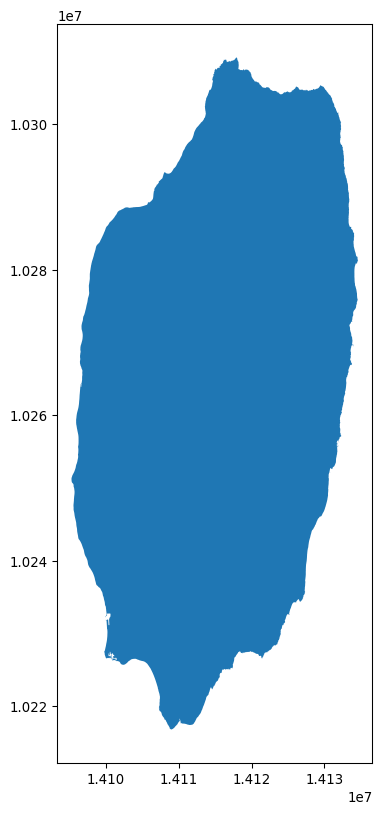

In [36]:
shp_region = get_vectorfile_ign(
  borders = "REGION", field = "metropole",
  source = "COG", provider="opendatarchives")

fig,ax = plt.subplots(figsize=(10, 10))
shp_region.to_crs(5070).plot(ax = ax)
ax

In [37]:
ax.set_axis_off()
ax
plt.tight_layout(pad=0, h_pad = 0)
plt.show()
#plt.savefig('reproj1.png', bbox_inches='tight')

<Figure size 672x480 with 0 Axes>

On le voit, cela modifie totalement la représentation de l’objet dans l’espace.
Clairement, cette projection n’est pas adaptée aux longitudes et latitudes françaises.
C’est normal, il s’agit d’une projection adaptée au continent
nord-américain (et encore, pas dans son ensemble !).

<AxesSubplot: >

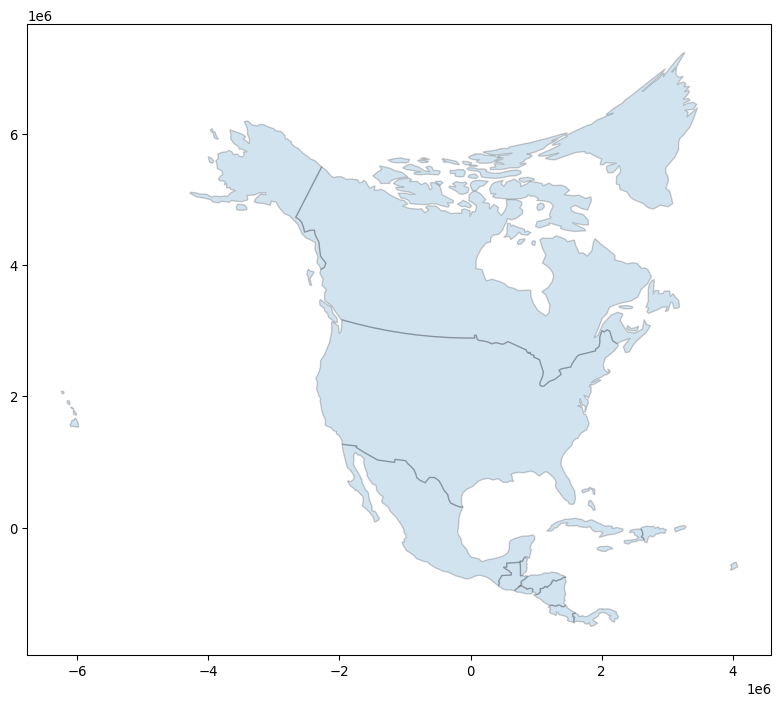

In [38]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig,ax = plt.subplots(figsize=(10, 10))
world[world.continent == "North America"].to_crs(5070).plot(alpha = 0.2, edgecolor = "k", ax = ax)
ax

In [39]:
plt.tight_layout(pad=0, h_pad = 0)
plt.show()
#plt.savefig('reproj2.png', bbox_inches='tight')

<Figure size 672x480 with 0 Axes>

# Joindre des données

## Joindre des données sur des attributs

Ce type de jointure se fait entre un objet géographique et un
deuxième objet, géographique ou non. A l’exception de la question
des géométries, il n’y a pas de différence par rapport à `Pandas`.

La seule différence avec `Pandas` est dans la dimension géographique.
Si on désire conserver la dimension géographique, il faut faire
attention à faire :

``` python
geopandas_object.merge(pandas_object)
```

Si on utilise deux objets géographiques mais ne désire conserver qu’une seule
dimension géographique<a name="cite_ref-2"></a>[<sup>\[2\]</sup>](#cite_note-2), on fera

``` python
geopandas_object1.merge(geopandas_object2)
```

Seule la géométrie de l’objet de gauche
sera conservée, même si on fait un *right join*.

Il est techniquement possible d’avoir un `DataFrame` comportant plusieurs
géographies. Par exemple une géométrie polygone et une géométrie point
(le centroid). C’est néanmoins souvent compliqué à gérer et donc peu
recommandable.

## Prolongation possible : joindre des données sur dimension géographique

Le chapitre suivant permettra de mettre en oeuvre des
jointures géographiques.

<div class="alert alert-warning" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #ffc10780;">
<h3 class="alert-heading"><i class="fa fa-lightbulb-o"></i> Hint</h3>

Les jointures spatiales peuvent être très gourmandes en ressources (car il peut être nécessaire de croiser toutes les géométries de `x` avec toutes les géométries de `y`). Voici deux conseils qui peuvent vous aider :

-   Il est préférable de tester les jointures géographiques sur un petit échantillon de données, pour estimer le temps et les ressources nécessaires à la réalisation de la jointure.
-   Il est parfois possible d’écrire une fonction qui réduit la taille du problème. Exemple: vous voulez déterminer dans quelle commune se situe un logement dont vous connaissez les coordonnées et le département; vous pouvez écrire une fonction qui réalise pour chaque département une jointure spatiale entre les logements situés dans ce département et les communes de ce département, puis empiler les 101 tables de sorties.

</div>

# Annexe

## Récupération des données depuis data.gouv

Avec cette méthode, les données des limites administratives demandent donc un peu de travail pour être
importées car elles sont zippées (mais c’est un bon exercice !).

Le code suivant, dont les
détails apparaîtront plus clairs après la lecture de la partie
*[webscraping](webscraping)* permet de :

1.  Télécharger les données avec `requests` dans un dossier temporaire
2.  Les dézipper avec le module `zipfile`

La fonction suivante automatise un peu le processus :

In [40]:
import requests
import tempfile
import zipfile

url = 'https://www.data.gouv.fr/fr/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165'
temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open("{}/{}.zip".format(dirname, destname), 'wb').write(myfile.content)
  with zipfile.ZipFile("{}/{}.zip".format(dirname, destname), 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

In [41]:
download_unzip(url)

In [42]:
shp_communes = gpd.read_file(temporary_location + "/borders/communes-20220101.shp")

Ici, les données ne sont pas projetées puisqu’elles sont dans le
système WSG84 (epsg: 4326) ce qui permet de facilement ajouter
un fonds de carte `Openstreetmap` ou `Stamen` pour rendre une représentation
graphique plus esthétique.
En toute rigueur, pour faire une carte statique d’un pays en particulier,
il faudrait reprojeter les données dans un système de projection adapté à la zone géographique étudiée
(par exemple le Lambert-93 pour la France métropolitaine).

On peut ainsi représenter Paris pour se donner une idée de la nature
du shapefile utilisé :

In [43]:
paris = shp_communes.loc[shp_communes['insee'].str.startswith("75")]

fig,ax = plt.subplots(figsize=(10, 10))
paris.plot(ax = ax, alpha=0.5, edgecolor='blue')
ctx.add_basemap(ax, crs = paris.crs.to_string())
ax.set_axis_off()
ax

On voit ainsi que les données pour Paris ne comportent pas d’arrondissement,
ce qui est limitant pour une analyse focalisée sur Paris. On va donc les
récupérer sur le site d’open data de la ville de Paris et les substituer
à Paris :

In [44]:
arrondissements = gpd.read_file("https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
arrondissements = arrondissements.rename(columns = {"c_arinsee": "insee"})
arrondissements['insee'] = arrondissements['insee'].astype(str)
shp_communes = shp_communes[~shp_communes.insee.str.startswith("75")].append(arrondissements)

Pour produire la carte, il faudrait faire:

In [45]:
paris = shp_communes.loc[shp_communes.insee.str.startswith("75")]

fig,ax = plt.subplots(figsize=(10, 10))

paris.plot(ax = ax, alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs = paris.crs.to_string())
ax.set_axis_off()
ax

## Récupération des données depuis le package `pynsee`

Pour connaître les contraintes d’installation du package `pynsee`,
se référer à la partie de cours dédiée à `Pandas`.

In [46]:
#le téléchargement des données prend plusieurs minutes
from pynsee.geodata import get_geodata
shp_communes = gpd.GeoDataFrame(
  get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')
)
shp_communes = shp_communes.rename({"insee_com": 'insee'}, axis = 'columns')
#shp_communes = shp_communes.set_crs(3857)